## Chapter 12 - Bayesian Approaches to Testing a Point ("Null") Hypothesis

- [12.2.2 - Are different groups equal or not?](#12.2.2---Are-different-groups-equal-or-not?)

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import theano.tensor as tt
from matplotlib import gridspec

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn,theano

pandas    : 1.3.0
numpy     : 1.21.1
pymc3     : 3.11.2
matplotlib: 3.4.2
seaborn   : 0.11.1
theano    : 1.1.2



#### Data
Using *R*, I executed lines 18-63 from the script `OneOddGroupModelComp2E.R` to generate the exact same data used in the book. The script can be downloaded from the book's website. After executing the lines, the List object `dataList` in *R* contains five elements:
 1. `nCond`: A scalar value (4) representing the number of conditions (background music types).
 2. `nSubj`: A scalar value (80) representing the number of subjects.
 3. `CondOfSubj`: A vector representing the condition (1, 2, 3 or 4) of a subject during a test.
 4. `nTrlOfSubj`: A vector with the number of trials/words per subject (20 for all subjects).
 5. `nCorrOfSubj`: A vector with number of correct recalls per subject.
 
I exported the last three elements of `dataList` to a csv file using the following command in *R*:   
`write.csv(data.frame(dataList[c(3:5)]), file='background_music.csv', row.names=FALSE)`

In [3]:
df = pd.read_csv('data/background_music.csv', dtype={'CondOfSubj':'category'})

# Mapping the condition descriptions to the condition codes. Just for illustrative purposes.
bgmusic = {0:'Das Kruschke', 1:'Mozart', 2:'Bach', 3:'Beethoven'}
df['CondText'] = df.CondOfSubj.cat.codes.map(bgmusic)

cond_idx = df.CondOfSubj.cat.codes.values
cond_codes = df.CondOfSubj.cat.categories
nCond = cond_codes.size

nSubj = df.index.size

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   CondOfSubj   80 non-null     category
 1   nTrlOfSubj   80 non-null     int64   
 2   nCorrOfSubj  80 non-null     int64   
 3   CondText     80 non-null     object  
dtypes: category(1), int64(2), object(1)
memory usage: 2.1+ KB


In [4]:
df.groupby('CondOfSubj').head(3)

,CondOfSubj,nTrlOfSubj,nCorrOfSubj,CondText
0,1,20,8,Das Kruschke
1,1,20,7,Das Kruschke
2,1,20,8,Das Kruschke
20,2,20,9,Mozart
21,2,20,12,Mozart
22,2,20,9,Mozart
40,3,20,11,Bach
41,3,20,6,Bach
42,3,20,11,Bach
60,4,20,6,Beethoven


### 12.2.2 - Are different groups equal or not?
Given the data, how credible is it that the 4 types of background music influence the ability to recall words 
**differently**?

In [5]:
# The means as mentioned in section 12.2.2
df.groupby('CondText', sort=False)['nCorrOfSubj'].mean()

CondText
Das Kruschke     8.0
Mozart          10.0
Bach            10.2
Beethoven       10.4
Name: nCorrOfSubj, dtype: float64

Note: in contrast to the *R* output in the book, the parameters in PyMC3 (like $\omega$ and model index) are indexed starting with 0.


Model 0 = condition specific $\omega_c$   
Model 1 = same $\omega$ for all conditions

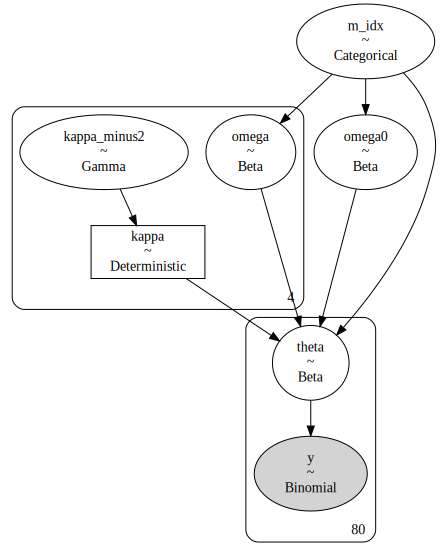

In [6]:
with pm.Model() as model_1:
    # constants
    aP, bP = 1., 1.
    
    # Pseudo- and true priors for model 1.  
    a0 = tt.as_tensor([.48*500, aP])      
    b0 = tt.as_tensor([(1-.48)*500, bP])
    
    # True and pseudopriors for model 0
    a = tt.as_tensor(np.c_[np.tile(aP, 4), [(.40*125), (.50*125), (.51*125), (.52*125)]])
    b = tt.as_tensor(np.c_[np.tile(bP, 4), [(1-.40)*125, (1-.50)*125, (1-.51)*125, (1-.52)*125]])        
  
    # Prior on model index [0,1]
    m_idx = pm.Categorical('m_idx', np.asarray([.5, .5]))
    
    # Priors on concentration parameters
    kappa_minus2 = pm.Gamma('kappa_minus2', 2.618, 0.0809, shape=nCond)
    kappa = pm.Deterministic('kappa', kappa_minus2 +2)
        
    # omega0 
    omega0 = pm.Beta('omega0', a0[m_idx], b0[m_idx])    
        
    # omega (condition specific)
    omega = pm.Beta('omega', a[:,m_idx], b[:,m_idx], shape=nCond)
    
    # Use condition specific omega when m_idx = 0, else omega0
    aBeta = pm.math.switch(pm.math.eq(m_idx, 0), omega * (kappa-2)+1, omega0 * (kappa-2)+1)
    bBeta = pm.math.switch(pm.math.eq(m_idx, 0), (1-omega) * (kappa-2)+1, (1-omega0) * (kappa-2)+1)

    # Theta
    theta = pm.Beta('theta', aBeta[cond_idx], bBeta[cond_idx], shape=nSubj)
    
    # Likelihood
    y = pm.Binomial('y', n=df.nTrlOfSubj.values, p=theta, observed=df.nCorrOfSubj)

pm.model_to_graphviz(model_1)

In [7]:
with model_1:
    trace1 = pm.sample(5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m_idx]
>NUTS: [theta, omega, omega0, kappa_minus2]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 25 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


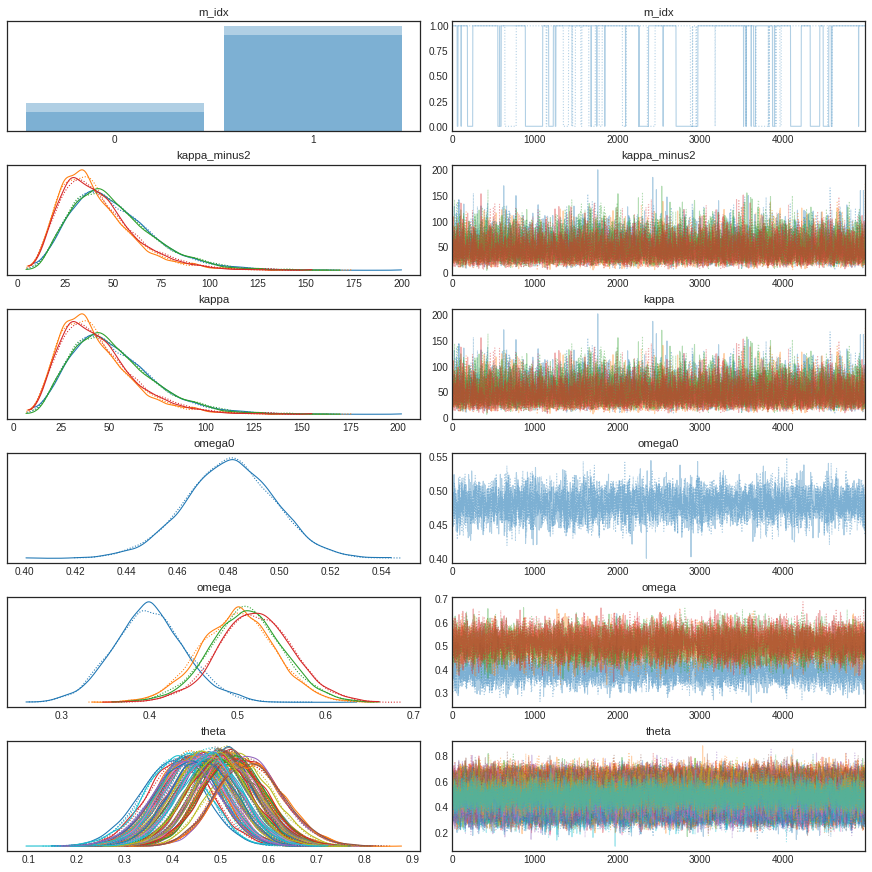

In [8]:
az.plot_trace(trace1);

#### Figure 12.5

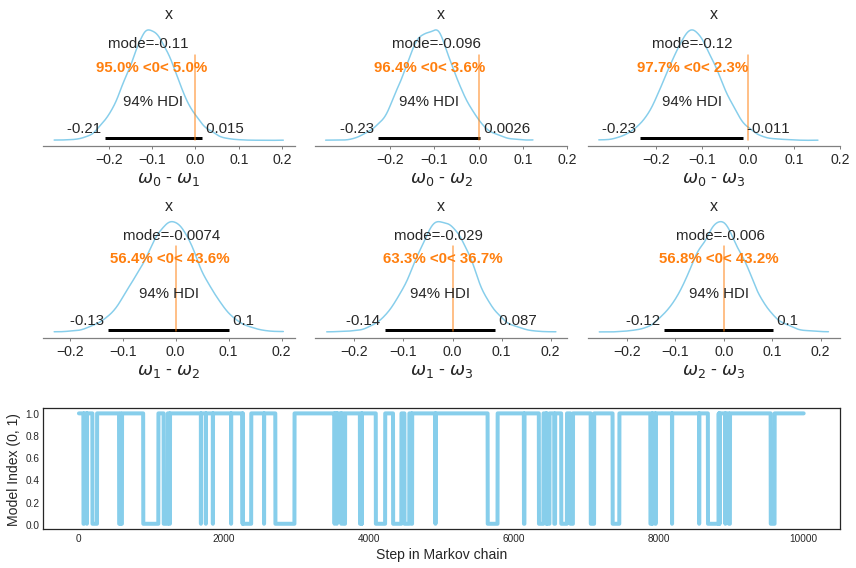

In [9]:
fig = plt.figure(figsize=(12,8))

# Define gridspec
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])
ax7 = plt.subplot(gs[2,:])

# Group the first six axes in a list for easier access in loop below
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
# Differences of posteriors to be displayed: omega x - omega y
x = [0,0,0,1,1,2]
y = [1,2,3,2,3,3]

# Plot histograms
for ax, a, b in zip(axes, x, y):
    diff = trace1['omega'][:,a]-trace1['omega'][:,b]
    az.plot_posterior(diff, ref_val=0, point_estimate='mode', color=color, ax=ax)
    ax.set_xlabel('$\omega_{}$ - $\omega_{}$'.format(a,b), fontdict={'size':18})
    ax.xaxis.set_ticks([-.2, -.1, 0.0, 0.1, 0.2])

# Plot trace values of model index (0, 1)
ax7.plot(np.arange(1, len(trace1['m_idx'])+1),trace1['m_idx'], color=color, linewidth=4)
ax7.set_xlabel('Step in Markov chain', fontdict={'size':14})
ax7.set_ylabel('Model Index (0, 1)', fontdict={'size':14})
ax7.set_ylim(-0.05,1.05)

fig.tight_layout()